# Group of relevance analysis
## Imports

In [20]:
from os.path import join as jn
import networkx as nx
import numpy as np
import scipy
import matplotlib.pyplot as plt
import itertools
import re
from Bio.PDB.Polypeptide import aa1, aa3
import seaborn as sns
import pandas as pd
import matplotlib.patches as mpatches
plt.style.use('default')
%matplotlib inline
import matplotlib as mpl
mpl.rc('figure', fc = 'white')
from sklearn.cluster import Birch
from Bio.PDB.Polypeptide import aa1, aa3
from Bio.PDB import PDBParser
from Bio.PDB.PDBExceptions import PDBConstructionWarning
import warnings
warnings.simplefilter('ignore', PDBConstructionWarning)
three2one = dict(zip(aa3, aa1))

## Loading data

In [6]:
results_folder = '/run/media/aria/3d8d23f2-fbab-4f49-969f-cc936ae32f73/RESULTS/GUIDELINES/'
L_cutoffs = list(range(3,10))

def get_net_list(string):
    paths = [jn(results_folder, string, "cutoff%s", '0.p') % i for i in L_cutoffs]
    return {i: nx.read_gpickle(path) for i, path in zip(L_cutoffs, paths)}   
titles = ['FULL', 'FULLH', 'BACKBONE', 'BACKBONEH', 'SIDECHAIN', 'SIDECHAINH']
full, fullH, backbone, backboneH, sidechain, sidechainH = [get_net_list(string) for string in titles]
L_dict_net = [full, fullH, backbone, backboneH, sidechain, sidechainH]

## Definition of functions

In [7]:
def get_group_of_relevance(dict_net, cutoff, k=5):
    net = dict_net[cutoff]
    weights = np.array([net.edges()[(u,v)]['weight'] for (u, v) in net.edges()]).reshape(-1, 1)
    birch = Birch(n_clusters=None).fit(weights)
    labels = birch.predict(weights)

    num_labels = np.max(labels)+1

    order = np.argsort(weights[:,0])
    ordered_labels = labels[order]
    ordered_weights = weights[order]
    ordered_edges = np.array(net.edges())[order]
    
    thresh = []
    num_elements = []
    edges_by_cluster = []
    for label in range(num_labels):
        id_label = ordered_labels == label
        _weights = ordered_weights[id_label]
        edges_by_cluster.append(ordered_edges[id_label])
        X = np.where(ordered_labels == label)
        thresh.append(min(_weights)[0])
        num_elements.append(X[0].shape[0])

    cumsum_elements = np.cumsum(np.sort(np.array(num_elements)))
    df = pd.DataFrame({'Label': range(num_labels), 'Threshold': thresh, 'Number of elements': num_elements,
                      'Edges': edges_by_cluster}).sort_values(by=['Threshold'], ascending=False)
    df['Cumulative'] = cumsum_elements
    rows = df.iloc[:k]
    edges_to_keep = [L_edge for L_edge in rows['Edges']]        
    return edges_to_keep

## Drawing network

In [83]:
pdb_path = '/run/media/aria/3d8d23f2-fbab-4f49-969f-cc936ae32f73/These/pdb/base_IGPS.pdb'
    
def draw_IGPS(net, edges_to_keep, ax=None):
    """A specific drawing adapted to IGPS this should be tunable for other proteins"""
    if ax == None:
        ax = plt.gca()
    structure = PDBParser().get_structure('X', pdb_path)[0]
    pos = {}
    distance_thresh = 1
    for atom in structure.get_atoms():
        if atom.id == 'CA':
            residue = atom.parent
            c = 1*(residue.parent.id == 'H') #Separate hisH and hisF
            if residue.resname in three2one:
                    "these values represents the 2D projection of IGPS in our classical view"
                    y = (0.1822020302*atom.coord[0] + 0.6987674421*atom.coord[1] - 0.6917560857*atom.coord[2])*(1-0.5*c)
                    x = 0.9980297273*atom.coord[0]+ 0.0236149631*atom.coord[1]+ 0.05812914*atom.coord[2]
                    pos[three2one[residue.resname]+str(residue.id[1])+':'+residue.parent.id] = (x, y)    
        
    # Getting nodes
    nodes = []
    for L_edges in edges_to_keep:
        for u, v in L_edges:
            nodes+=[u, v]
    nodes = set(nodes)
    
    #Springing nodes
    _pos=nx.spring_layout(nodes, pos=pos, iterations=5)
    pos.update(_pos)
    
    #Drawing nodes
    nx.draw_networkx_nodes(net, pos, 
                           nodelist=nodes,
                           node_size=500, 
                           node_shape='o', 
                           node_color='lightgrey',
                           ax=ax
                          )
    #Handling labels
    nx.draw_networkx_labels(net, 
                            pos, 
                            nodelist=nodes, 
                            labels={node: node[:-2] if node in nodes else '' for node in net.nodes()}, 
                            font_size=16, 
                            font_weight='bold',
                            ax=ax
                           )
    #Handling edges
    i2color =  dict(zip(range(len(edges_to_keep)), sns.color_palette("colorblind", len(edges_to_keep))))
    handles = []
    for i, L_edges in enumerate(edges_to_keep):
        colors = [net.edges()[(u, v)]['color'] for (u, v) in L_edges]
        style = np.apply_along_axis(lambda x: 'dotted' if x[0]=='g' else 'solid', -1, colors)
        edgelist = [(u, v) for (u, v) in L_edges]
        nx.draw_networkx_edges(net, pos,
                                edgelist=edgelist,
                                width=5,
                                alpha=1,
                                edge_color=[i2color[i]],
                                style=style, 
                                ax=ax
                              )
        
#         nx.draw_networkx_edges(net, pos, 
#                                edgelist=edgelist, 
#                                width=10, 
#                                alpha=1,
#                                edge_color=colors,
#                                ax=ax
#                               )
        handles.append(mpatches.Patch(color=i2color[i], label='Group %s' %i))
    plt.legend(handles=handles, ncol=2, loc='upper left')
        
def draw_groups(dict_net, cutoff, k=5, ax=None):
    edges_to_keep = get_group_of_relevance(dict_net=dict_net, cutoff=cutoff, k=k)
    draw_IGPS(dict_net[cutoff], edges_to_keep, ax=ax)   

## Test drawing

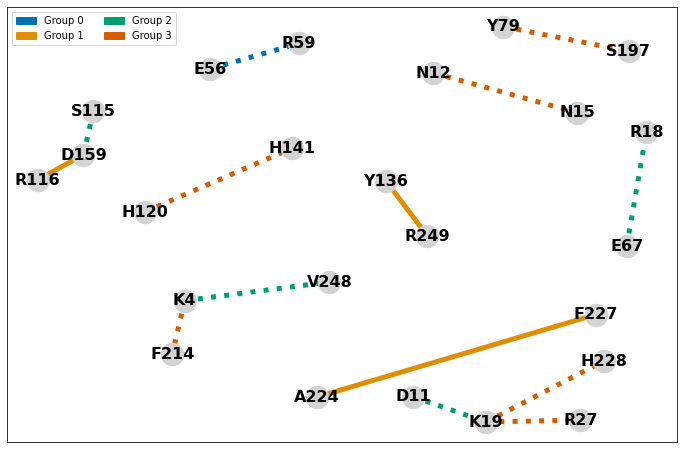

In [87]:
fig, ax = plt.subplots(1, 1, figsize=[12, 8])
draw_groups(full, cutoff=5, k=4, ax=ax)

## Network to VMD

In [ ]:
structure = PDBParser().get_structure('X', pdb_path)[0]
node2CA = {}
for atom in structure.get_atoms():
    if atom.id == 'CA':
        residue = atom.parent
        if residue.resname in three2one:
                coords = str(atom.coord[0]) + ' ' + str(atom.coord[1]) + ' ' + str(atom.coord[2])
                node2CA[three2one[residue.resname]+str(residue.id[1])+':'+residue.parent.id] = coords
    if args.m:
        if atom.id == args.m[1] and atom.parent.resname == args.m[0]:
            coords = str(atom.coord[0]) + ' ' + str(atom.coord[1]) + ' ' + str(atom.coord[2])
            node2CA[atom.parent.resname+str(atom.parent.id[1])+':'+atom.parent.parent.id] = coords
            print(atom.parent.resname+str(atom.parent.id[1])+':'+atom.parent.parent.id)
div = None
output.write('draw delete all \n')
previous = None
if (not div and args.same) or not args.same:
    div = max(nx.get_edge_attributes(A, 'weight').values())/args.norm
for u, v in A.edges():
    if color:
        c = A.get_edge_data(u, v)['color']
        if c == 'g':
            c = args.c[1]
        if c == 'r':
            c = args.c[0] 
        if previous != c:
            output.write('draw color ' +c+'\n')
            previous = c  
        if args.ntodraw:
            if u in args.ntodraw and v in args.ntodraw:
                output.write('draw cylinder { ' + str(node2CA[u]) + ' '+ ' } ' + '{ ' + str(node2CA[v]) + ' '+ ' } radius '+str(A.get_edge_data(u, v)['weight']/div)+' \n')
        else:
            try:
                output.write('draw cylinder { ' + str(node2CA[u]) + ' '+ ' } ' + '{ ' + str(node2CA[v]) + ' '+ ' } radius '+str(A.get_edge_data(u, v)['weight']/div)+' \n')
            except KeyError:
                pass
    else:
        output.write('draw color '+args.c[2]+'\n')
        if args.ntodraw:
            if u in args.ntodraw and v in args.ntodraw:
                output.write('draw cylinder { ' + str(node2CA[u]) + ' '+ ' } ' + '{ ' + str(node2CA[v]) + ' '+ ' } radius '+str(A.get_edge_data(u, v)['weight']/div)+' \n')
        else:
            try:                    
                output.write('draw cylinder { ' + str(node2CA[u]) + ' '+ ' } ' + '{ ' + str(node2CA[v]) + ' '+ ' } radius '+str(A.get_edge_data(u, v)['weight']/div)+' \n')
            except KeyError:
                print('error drawing node ', u)
output.write('draw color silver \n')
for u in A.nodes():
    if args.ntodraw:
        if u in args.ntodraw:
            output.write('draw sphere { ' + str(node2CA[u]) + ' '+ ' } radius '+str(args.norm)+' \n')
    else:
        try:
            output.write('draw sphere { ' + str(node2CA[u]) + ' '+ ' } radius '+str(args.norm)+' \n')
        except KeyError:
            if not args.m:
                print('Warning, residue', u, 'probably mutated between the two networks')